#0. 準備

##0.1. google driveへ接続

##0.2. ファイル名の指定と、各種パスを自動で生成

In [13]:
#------------------------------------------------------------------------------
#ここを変更
#------------------------------------------------------------------------------
INPUT_FILE="/content/drive/My Drive/datasets/C0003.MP4" #動画までのパス #ここで動画名を指定すれば、関節座標を記録したcsv (動画と同じディレクトリに保存されている) までのパスとファイル名も自動で作成される。
OUTPUT_PATH="/content/drive/My Drive/研究室/Personal/Assets/Assets_Output/HRNet/" #最終的な動画をどこのディレクトリへ保存するか。

sub_CSV_FILE="/content/drive/My Drive/研究室/Personal/Assets/Assets_Output/HRNet/pose-data_C0219.csv" #比較する別の関節座標
#------------------------------------------------------------------------------

#------------------------------------------------------------------------------
#removed pathANDformat from videoFile  by mayo 
#------------------------------------------------------------------------------
INPUT_FILE_splited_path=INPUT_FILE.split('/')
INPUT_FILE_removed_pathANDformat=INPUT_FILE_splited_path[-1].split(".")
INPUT_FILE_removed_pathANDformat=INPUT_FILE_removed_pathANDformat[0]

POSE_FILE=OUTPUT_PATH+'pose_%s.MP4' % INPUT_FILE_removed_pathANDformat
#------------------------------------------------------------------------------

#------------------------------------------------------------------------------
#関節座標を記録したcsv (動画と同じディレクトリに保
#存されている) までのパスとファイル名を生成
#------------------------------------------------------------------------------
CSV_FILE= OUTPUT_PATH+ "pose-data_%s.csv" % INPUT_FILE_removed_pathANDformat
print(CSV_FILE)
OUTPUT_FILE= OUTPUT_PATH+ "pose_%s.MP4" % INPUT_FILE_removed_pathANDformat
print(OUTPUT_FILE)
#------------------------------------------------------------------------------

/content/drive/My Drive/研究室/Personal/Assets/Assets_Output/HRNet/pose-data_C0003.csv
/content/drive/My Drive/研究室/Personal/Assets/Assets_Output/HRNet/pose_C0003.MP4


#1. 関節座標の取得



##1.1. csvからdfへ変換

df_A : メインとなる関節座標

df_B : その比較に使う関節座標

In [14]:
import pandas as pd
import re

def read_file_keypoints(CSV_FILE):
    df=pd.read_csv(CSV_FILE, encoding = "shift-jis")
    df=df.set_index('frame')
    x_len, y_len=df.shape
    #print(x_len, y_len)

    list_colums_name=list(df.columns)
    list_keypoints_label_x, list_keypoints_label_y= [], []
    list_keypoints_label_x.clear()
    list_keypoints_label_y.clear()
    for element in list_colums_name:
     if re.search('_y', element):
       list_keypoints_label_y.append(element)
     else:
       list_keypoints_label_x.append(element)

    df_keypoints_y=df.loc[:, list_keypoints_label_y]
    #print(df_keypoints_y) #y位相だけのdf #これをメインに使います。
    list_coords_y=df_keypoints_y.values.tolist()
      
    return df, list_coords_y, list_keypoints_label_y

df_A, list_coords_y_A, list_keypoints_label_y_A=read_file_keypoints(CSV_FILE)
df_B, list_coords_y_B, list_keypoints_label_y_B=read_file_keypoints(sub_CSV_FILE)

#print(list_keypoints_label_y_A)

#print(list_coords_y_A, list_coords_y_B)

##1.2. dfの確認

In [15]:
df_A

,nose_x,nose_y,left_eye_x,left_eye_y,right_eye_x,right_eye_y,left_ear_x,left_ear_y,right_ear_x,right_ear_y,left_shoulder_x,left_shoulder_y,right_shoulder_x,right_shoulder_y,left_elbow_x,left_elbow_y,right_elbow_x,right_elbow_y,left_wrist_x,left_wrist_y,right_wrist_x,right_wrist_y,left_hip_x,left_hip_y,right_hip_x,right_hip_y,left_knee_x,left_knee_y,right_knee_x,right_knee_y,left_ankle_x,left_ankle_y,right_ankle_x,right_ankle_y
frame,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,797,571,797,584,784,584,732,567,737,567,650,502,776,497,541,467,810,385,455,406,780,393,654,272,698,280,750,120,828,150,641,20,871,11
1,800,571,796,584,783,584,732,571,736,571,651,503,775,499,541,469,809,384,456,410,783,393,651,269,698,278,749,116,830,150,643,23,872,10
2,800,572,796,585,783,585,732,568,737,568,651,500,779,500,540,470,809,380,455,410,783,402,656,269,698,278,749,120,830,150,647,26,869,9
3,802,569,797,586,785,581,734,569,734,569,653,501,776,501,538,467,802,395,458,412,789,412,657,267,700,276,751,115,831,149,645,26,869,9
4,799,571,799,583,782,583,735,567,735,567,651,499,778,499,538,470,803,382,458,415,786,415,660,264,702,277,752,113,828,150,643,24,866,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,667,465,689,475,664,479,729,461,656,479,743,374,685,414,693,265,689,284,606,197,671,356,888,284,801,269,928,99,794,135,874,95,812,8
196,668,461,686,475,665,479,730,461,654,479,744,370,676,410,694,269,694,284,607,201,665,356,889,284,802,269,928,100,795,136,874,96,809,6
197,664,462,685,473,661,480,728,459,657,480,738,367,678,409,692,265,685,286,608,201,668,353,890,282,805,272,929,99,795,138,879,103,812,4


In [16]:
df_B

,nose_x,nose_y,left_eye_x,left_eye_y,right_eye_x,right_eye_y,left_ear_x,left_ear_y,right_ear_x,right_ear_y,left_shoulder_x,left_shoulder_y,right_shoulder_x,right_shoulder_y,left_elbow_x,left_elbow_y,right_elbow_x,right_elbow_y,left_wrist_x,left_wrist_y,right_wrist_x,right_wrist_y,left_hip_x,left_hip_y,right_hip_x,right_hip_y,left_knee_x,left_knee_y,right_knee_x,right_knee_y,left_ankle_x,left_ankle_y,right_ankle_x,right_ankle_y
frame,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,588,580,609,589,588,593,647,580,652,576,609,509,690,525,694,471,799,530,664,407,732,542,660,264,609,268,563,166,614,137,652,14,681,31
1,590,577,611,590,590,595,649,577,581,590,607,509,679,531,700,471,803,526,671,403,730,535,658,266,607,270,568,168,568,155,671,19,675,32
2,589,579,606,588,589,596,649,575,581,592,610,511,679,519,705,472,799,528,670,399,730,536,658,263,602,271,568,164,610,139,649,15,675,32
3,590,581,607,589,586,593,650,576,577,593,616,508,675,529,705,466,799,525,671,389,726,546,654,270,603,270,573,163,586,155,641,15,671,32
4,589,580,610,588,589,593,648,576,580,588,619,508,691,529,708,457,797,525,678,389,725,546,657,265,602,270,576,163,580,155,640,15,665,32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,747,504,751,520,732,512,759,520,692,504,664,480,668,413,652,381,660,337,692,333,688,281,573,293,485,305,605,127,394,162,620,4,350,349
196,748,503,752,519,731,515,760,515,694,507,658,483,670,417,662,384,658,339,690,335,686,286,572,298,490,303,604,127,392,163,621,4,347,348
197,751,503,755,520,731,516,759,520,690,507,661,483,665,413,649,380,657,331,690,343,685,286,567,294,489,306,599,130,390,167,620,3,349,347


##1.3. 関節部位の追加

4つの特徴量を追加する。



1.   middle_chest_x ←胸の中心 (x座標)
2.   middle_chest_y ←胸の中心 (y座標)
3.   wrist_chest_distance_right ←胸と右手首までの距離 (y座標のみ)
4.   wrist_chest_distance_left ←胸と左手首までの距離 (y座標のみ)



In [17]:
import numpy as np
#df_A

def expand_bodyRegion(df_element):
  df_element['middle_chest_x']=np.sqrt((df_element['left_shoulder_x']-df_element['right_shoulder_x'])**2)
  df_element['middle_chest_y']=np.sqrt((df_element['left_shoulder_y']-df_element['right_shoulder_y'])**2)

  df_element['from_Rhand_to_chest']=np.sqrt((df_element['middle_chest_x']- df_element['right_wrist_x'])**2+(df_element['middle_chest_x'] - df_element['right_wrist_y'])**2)
  df_element['from_Lhand_to_chest']=np.sqrt((df_element['middle_chest_y'] - df_element['left_wrist_x'])**2+(df_element['middle_chest_y'] - df_element['left_wrist_y'])**2)

  return df_element

df_A=expand_bodyRegion(df_A)
df_B=expand_bodyRegion(df_B)

In [18]:
df_A

,nose_x,nose_y,left_eye_x,left_eye_y,right_eye_x,right_eye_y,left_ear_x,left_ear_y,right_ear_x,right_ear_y,left_shoulder_x,left_shoulder_y,right_shoulder_x,right_shoulder_y,left_elbow_x,left_elbow_y,right_elbow_x,right_elbow_y,left_wrist_x,left_wrist_y,right_wrist_x,right_wrist_y,left_hip_x,left_hip_y,right_hip_x,right_hip_y,left_knee_x,left_knee_y,right_knee_x,right_knee_y,left_ankle_x,left_ankle_y,right_ankle_x,right_ankle_y,middle_chest_x,middle_chest_y,from_Rhand_to_chest,from_Lhand_to_chest
frame,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,797,571,797,584,784,584,732,567,737,567,650,502,776,497,541,467,810,385,455,406,780,393,654,272,698,280,750,120,828,150,641,20,871,11,126.0,5.0,706.402860,602.744556
1,800,571,796,584,783,584,732,571,736,571,651,503,775,499,541,469,809,384,456,410,783,393,651,269,698,278,749,116,830,150,643,23,872,10,124.0,4.0,711.787890,607.568926
2,800,572,796,585,783,585,732,568,737,568,651,500,779,500,540,470,809,380,455,410,783,402,656,269,698,278,749,120,830,150,647,26,869,9,128.0,0.0,710.000704,612.474489
3,802,569,797,586,785,581,734,569,734,569,653,501,776,501,538,467,802,395,458,412,789,412,657,267,700,276,751,115,831,149,645,26,869,9,123.0,0.0,726.000689,616.042206
4,799,571,799,583,782,583,735,567,735,567,651,499,778,499,538,470,803,382,458,415,786,415,660,264,702,277,752,113,828,150,643,24,866,12,127.0,0.0,719.183565,618.052587
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,667,465,689,475,664,479,729,461,656,479,743,374,685,414,693,265,689,284,606,197,671,356,888,284,801,269,928,99,794,135,874,95,812,8,58.0,40.0,681.595921,587.371262
196,668,461,686,475,665,479,730,461,654,479,744,370,676,410,694,269,694,284,607,201,665,356,889,284,802,269,928,100,795,136,874,96,809,6,68.0,40.0,662.837084,589.414964
197,664,462,685,473,661,480,728,459,657,480,738,367,678,409,692,265,685,286,608,201,668,353,890,282,805,272,929,99,795,138,879,103,812,4,60.0,42.0,674.917032,587.909007


#2. 関節座標を時間遷移でアニメーショングラフ化

##2.1. 部位ごとに静止画のグラフ化する。

plotting left_shoulder_y ...

       the directory already exists

       the directory already exists



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



       left_shoulder_y Done!

plotting right_shoulder_y ...

       the directory already exists

       the directory already exists



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



       right_shoulder_y Done!

plotting left_elbow_y ...

       the directory already exists

       the directory already exists




       left_elbow_y Done!

plotting right_elbow_y ...

       the directory already exists

       the directory already exists




       right_elbow_y Done!

plotting left_wrist_y ...

       the directory already exists

       the directory already exists




       left_wrist_y Done!

plotting right_wrist_y ...

       the directory already exists

       the directory already exists




       right_wrist_y Done!

plotting middle_chest_y ...

       the directory already exists

       the directory already exists




       middle_chest_y Done!

plotting from_Rhand_to_chest ...

       the directory already exists

       the directory already exists




       from_Rhand_to_chest Done!

plotting from_Lhand_to_chest ...

       the directory already exists

       the directory already exists




       from_Lhand_to_chest Done!



<Figure size 432x288 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

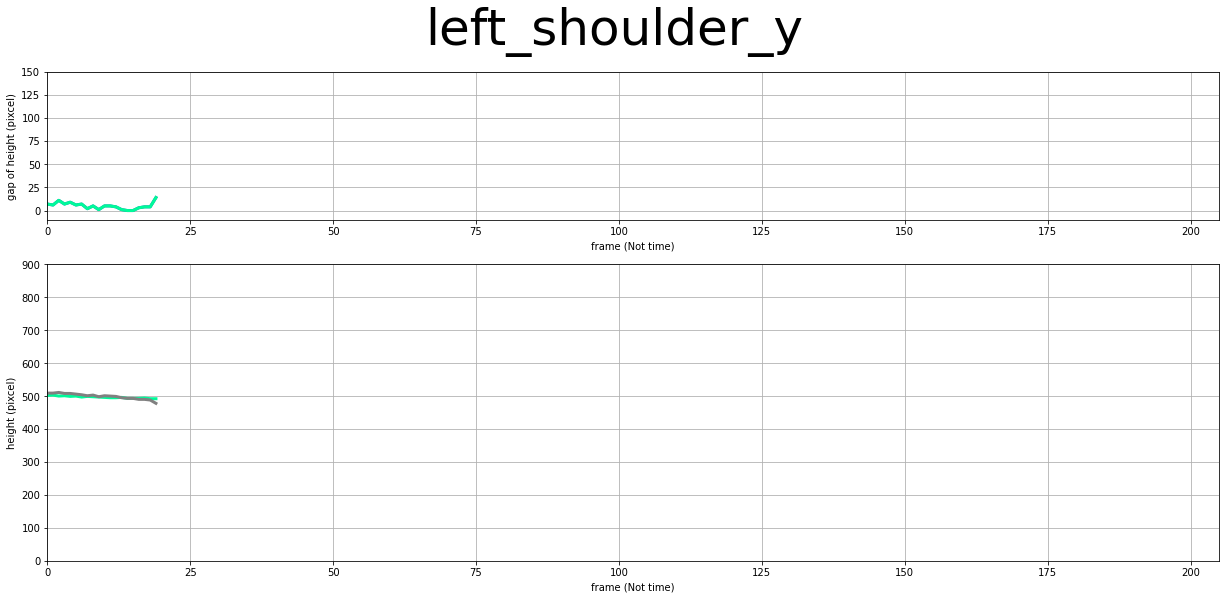

<Figure size 432x288 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

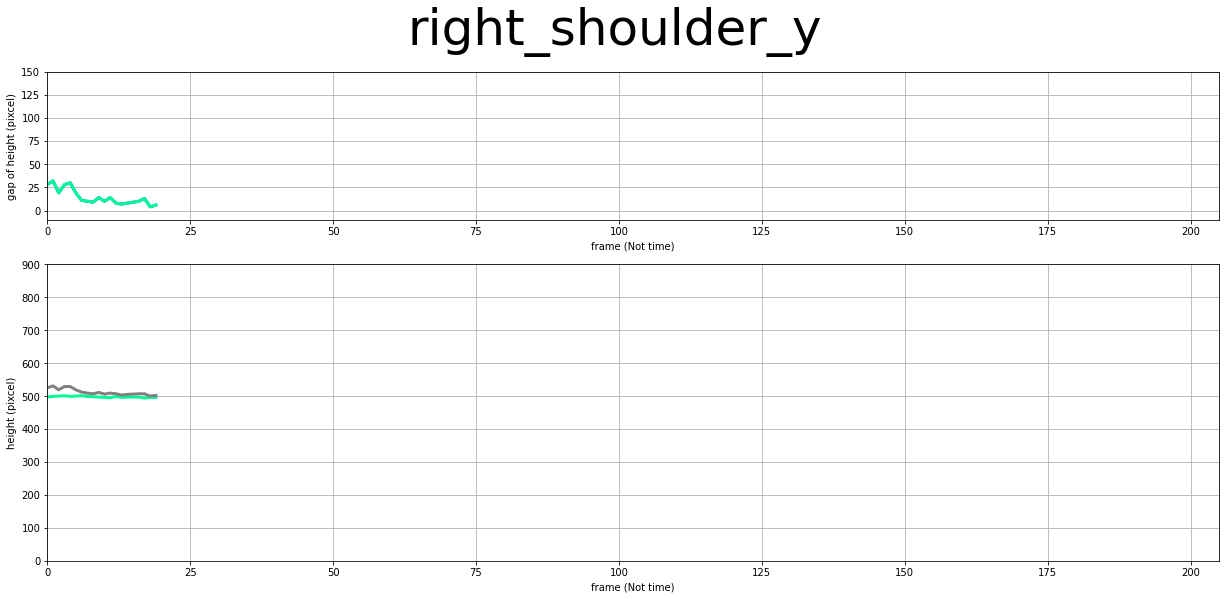

<Figure size 432x288 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

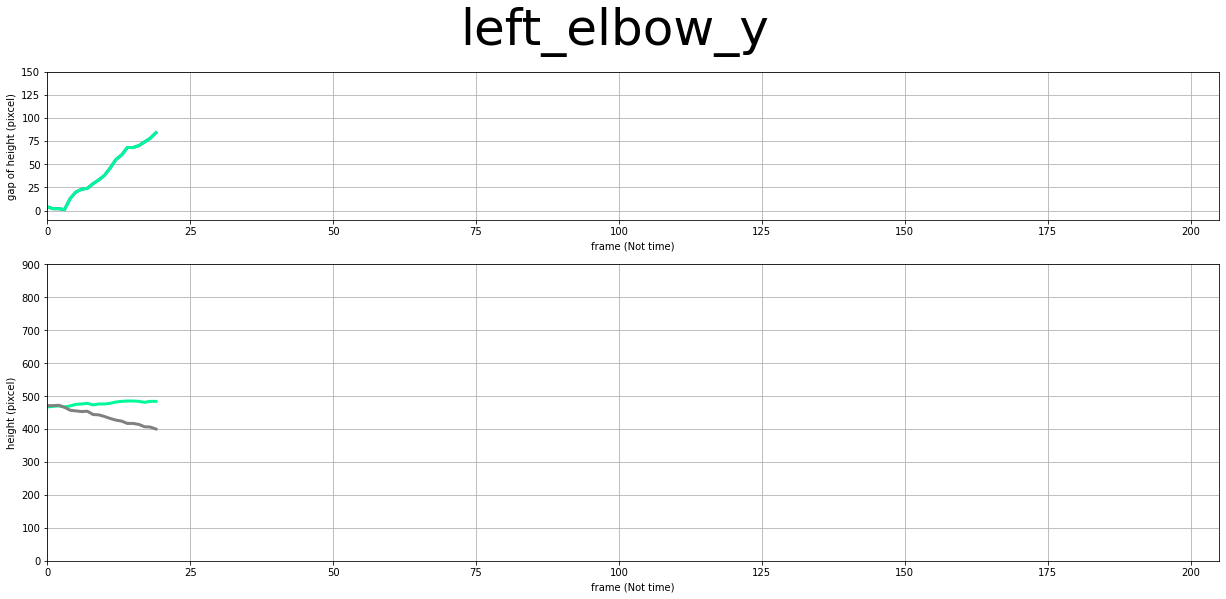

<Figure size 432x288 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

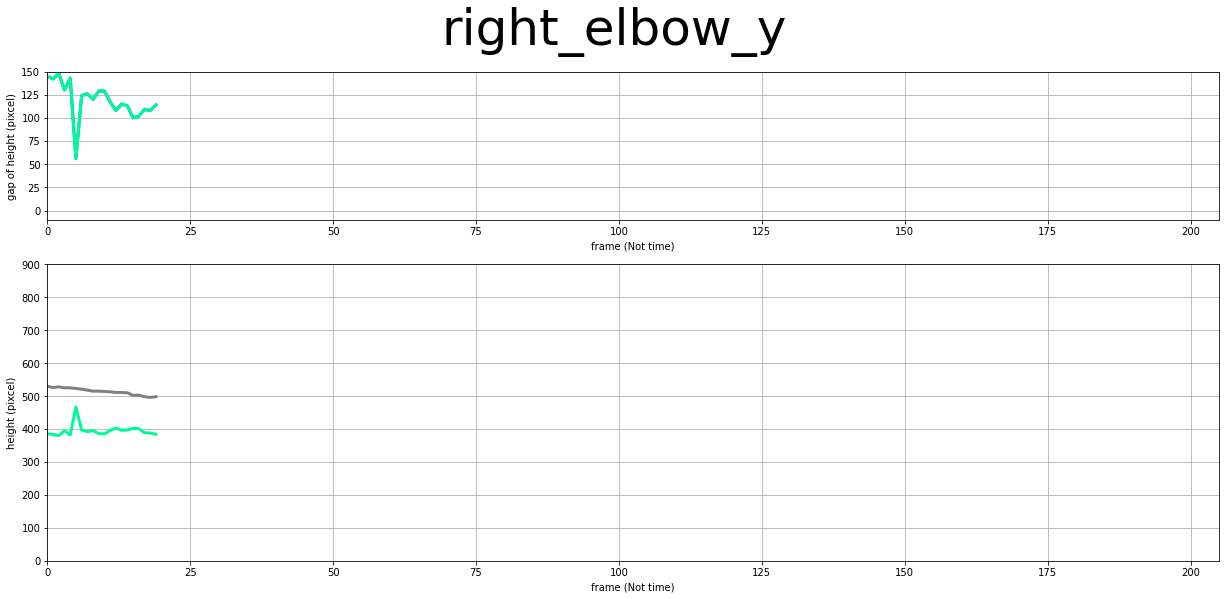

<Figure size 432x288 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

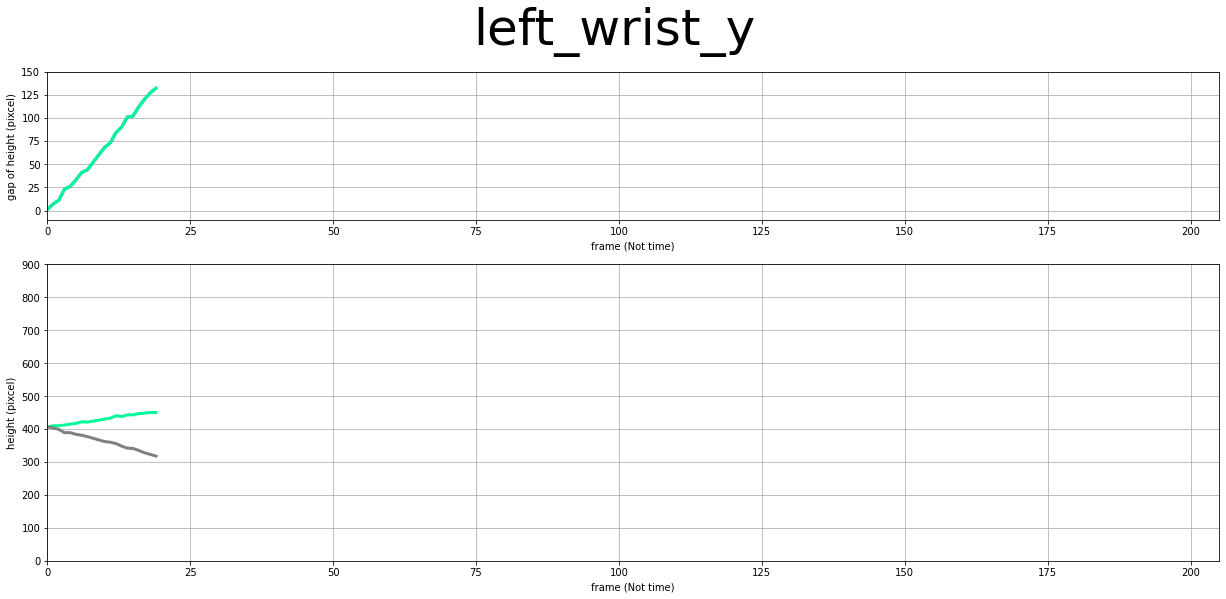

<Figure size 432x288 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

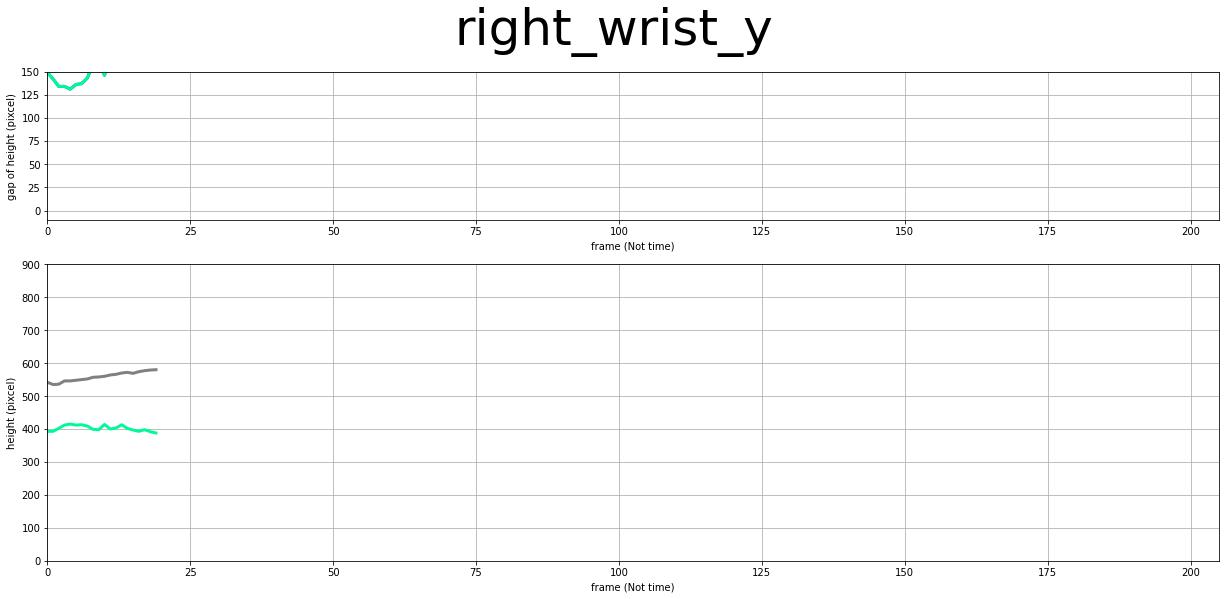

<Figure size 432x288 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

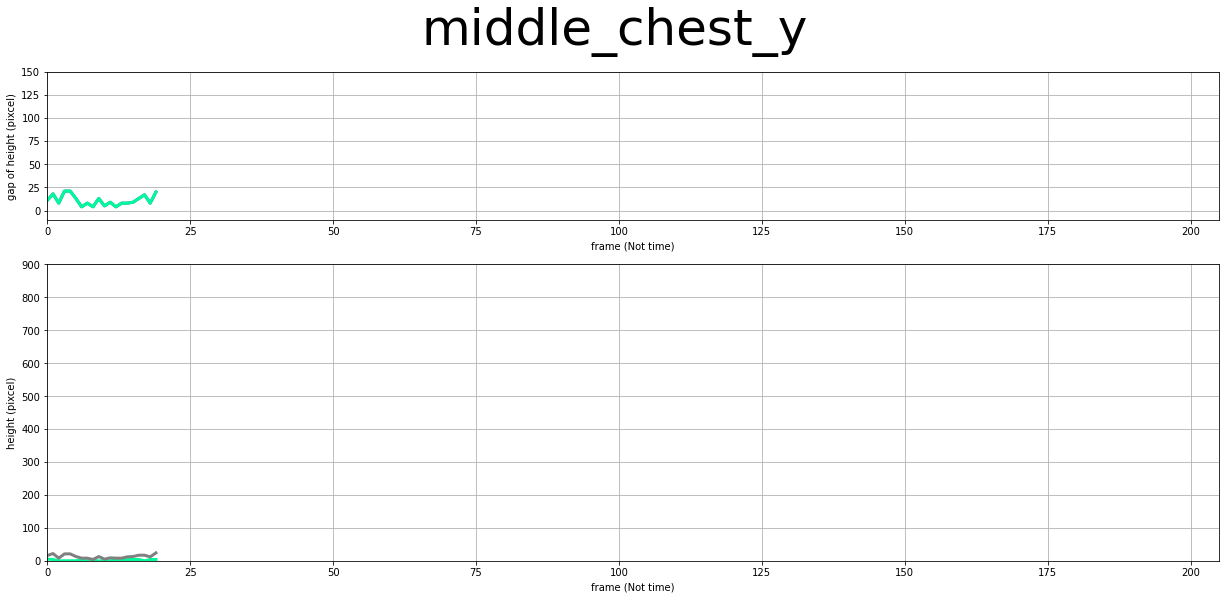

<Figure size 432x288 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

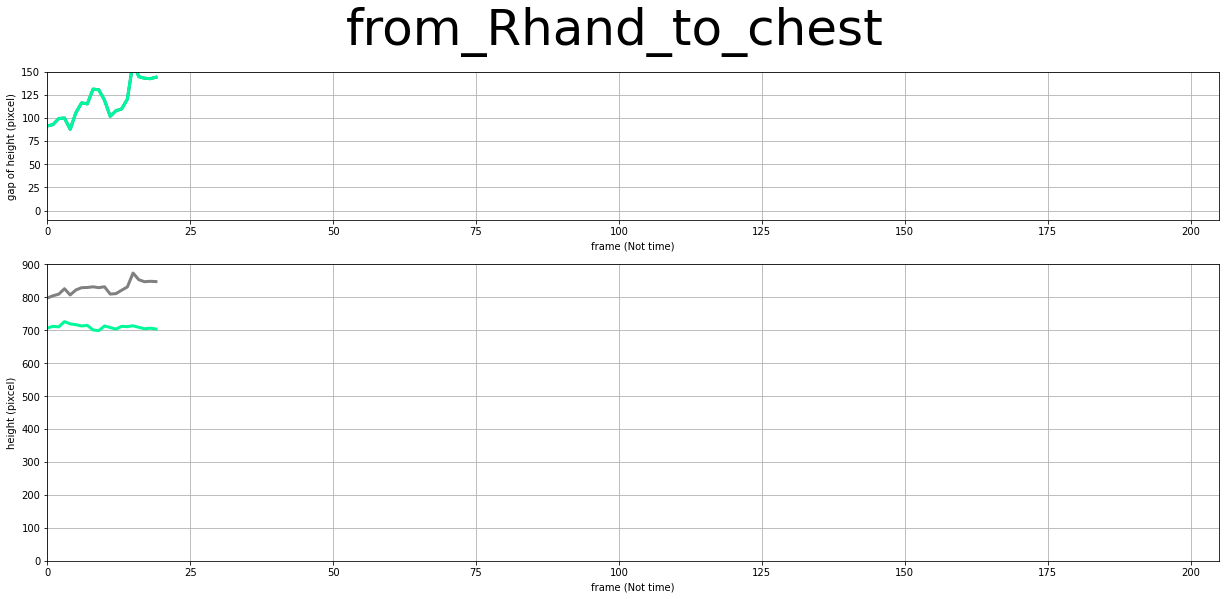

<Figure size 432x288 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

<Figure size 1512x648 with 0 Axes>

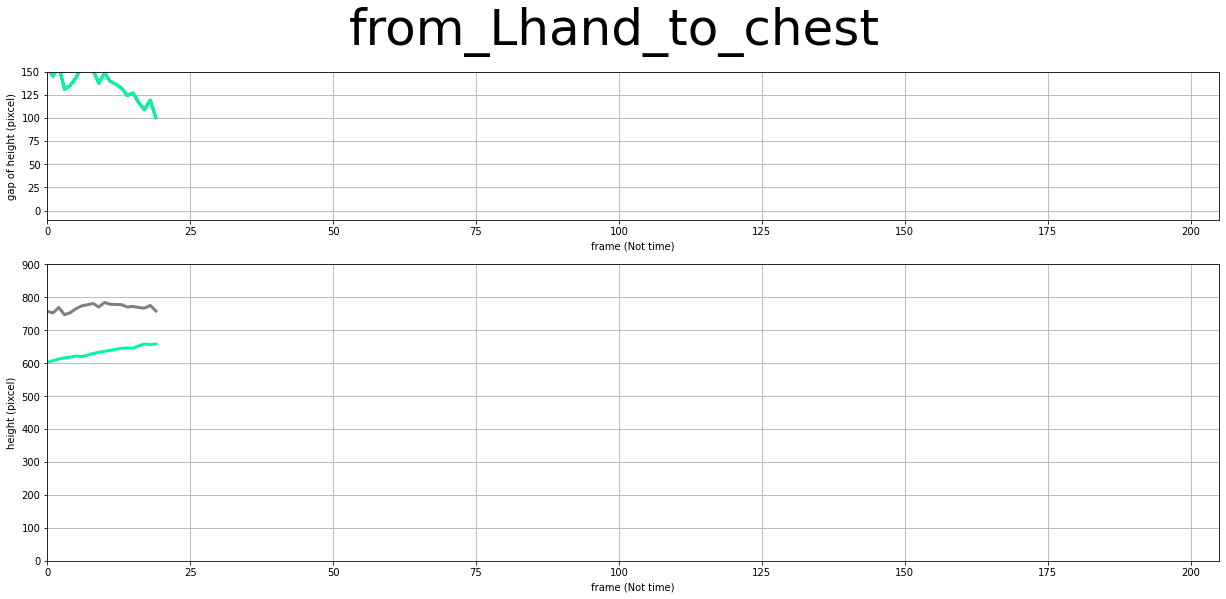

In [34]:
from matplotlib import pyplot as plt
from matplotlib import animation
from matplotlib import gridspec
%matplotlib inline

from tqdm.autonotebook import tqdm

PARTS_PATH="./fig/"

def AniFigure(PARTS_PATH, df_A, df_B):

    bodyRegion=['left_shoulder_y', 'right_shoulder_y', 'left_elbow_y', 'right_elbow_y', 'left_wrist_y', 'right_wrist_y', 'middle_chest_y',	'from_Rhand_to_chest',	'from_Lhand_to_chest'] #bodyRegion='部位(?)'

    #bodyRegion=['wrist_chest_distance_right',	'wrist_chest_distance_left']
    #------------------------------------------------------------------------------
    #関節部位ごとでグラフを作成する。
    #------------------------------------------------------------------------------
    for element in bodyRegion:
      print('plotting %s ...' % element)
      print()
      import os 
      try:
        os.mkdir(PARTS_PATH)
      except:
        print('       the directory already exists')
        print()
      try:
        os.mkdir(PARTS_PATH+element+"/")
      except:
        print('       the directory already exists')
        print()

      df_A_element=df_A['%s' % element]
      list_coords_onePart_A=df_A_element.values.tolist()

      df_B_element=df_B['%s' % element]
      list_coords_onePart_B=df_B_element.values.tolist()

      # 描画領域
      fig = plt.figure()
      # 描画するデータ (最初は空にする)
      list_x = []
      list_x.clear()
      #list_y = []
      #list_y.clear()

      list_y_dff=[]
      list_y_dff.clear()

      y_now, y_past=[], []
      y_now.clear()
      y_past.clear()     
      #------------------------------------------------------------------------------
      #グラフを更新する
      #------------------------------------------------------------------------------
      for frame in tqdm(range(0, 20,1)): #len(list_coords_onePart_A)
        plt.cla() #図をcloseする
        plt.clf() #図をclearする
        fig = plt.figure(figsize=(21,9))
        spec = gridspec.GridSpec(ncols=1, nrows=2, height_ratios=[1,2])
        ax1 = fig.add_subplot(spec[0])
        ax2 = fig.add_subplot(spec[1])

        #------------------------------------------------------------------------------
        #グラフ下半分について
        #------------------------------------------------------------------------------
        list_x.append(frame) 
        #print(list_coords_y[int(frame)])
        #--------------------------------------------
        #使わなくなった部分
        #--------------------------------------------
        #y_frame=[]
        #y_frame.clear()
        #y_frame.append(list_coords_onePart_A[int(frame)])
        #y_frame.append(list_coords_onePart_B[int(frame)])
        #y.append(y_frame)
        #--------------------------------------------
        #追加した部分
        #--------------------------------------------  
        y_now.append(list_coords_onePart_A[int(frame)])
        y_past.append(list_coords_onePart_B[int(frame)])
        #--------------------------------------------
        ax2.set_xlabel("frame (Not time)")
        ax2.set_ylabel("height (pixcel)")
        ax2.set_xlim((0, len(list_coords_onePart_A)+5))
        ax2.set_ylim((0,900))
        ax2.grid(True, axis='both')
        #ax2.plot(x, y, linewidth = 3)
        #print(y)
        ax2.plot(list_x, y_now, linewidth = 3, color='mediumspringgreen')
        ax2.plot(list_x, y_past, linewidth = 3, color='gray') #'lightskyblue'
        
        y_dff=abs(list_coords_onePart_A[int(frame)] - list_coords_onePart_B[int(frame)])
        list_y_dff.append(y_dff)

        ax1.set_xlabel("frame (Not time)")
        ax1.set_ylabel("gap of height (pixcel)")
        ax1.set_xlim((0, len(list_coords_onePart_A)+5))
        ax1.set_ylim((-10,150))
        ax1.grid(True, axis='both')
        #print(x, list_y_dff)
        ax1.plot(list_x, list_y_dff, linewidth = 3)
        ax1.plot(list_x, list_y_dff, linewidth = 3, color='mediumspringgreen')

        # 折れ線グラフを再描画する
        fig.suptitle('%s' % element , fontsize=50)
        plt.grid(True, axis='both')
        #plt.legend(['now', 'past'], bbox_to_anchor=(1.05, 1), loc='upper center', borderaxespad=0, fontsize=18)
        #plt.legend(['now', 'past'], ncol=2, borderaxespad=0., bbox_to_anchor=(0., 1.7, 1., 0.102), loc=3)
        plt.savefig(PARTS_PATH+element+"/AniFig_%s.jpg" % (str(frame).zfill(5)), transparent = True, bbox_inches = 'tight', pad_inches = 0.1)
        #plt.show()
      #------------------------------------------------------------------------------
      print('       %s Done!' % element)
      print()
      #------------------------------------------------------------------------------
      
AniFigure(PARTS_PATH, df_A, df_B)

##2.2. 静止画を重ねて動画を生成 (グラフを重ねてアニメーショングラフ化) する。

In [35]:
#------------------------------------------------------------------------------
#動画を生成
#------------------------------------------------------------------------------
def make_video(PATH, FILE):
  fps=59.94005994005994
  width =1920.0
  height =1080.0
  frames =270.0
  
  import glob
  images = glob.glob(PATH + "*.jpg")
  from natsort import natsorted
  images=sorted(images)

  import cv2
  print("画像を結合して動画を作成します...")
  fourcc = cv2.VideoWriter_fourcc('m','p','4','v')
  PATH="./fig/" #動画を結合する関数の汎用化に合わせて、こ子でPATHを書き換えていることに注意。
  video = cv2.VideoWriter(PATH + FILE, fourcc, fps, (int(width), int(height)))

  from tqdm.autonotebook import tqdm
  for i in tqdm(range(len(images))):
     img = cv2.resize(cv2.imread(images[i]),(int(width),int(height)))
     video.write(img) 

  video.release()
  print("%sにおいて、\n%sを作成しました。" % (PATH, FILE))
  print()

  #print('使用済みデータを削除します...')
  #import os
  #for i in range(len(images)):
    #os.remove(images[i])

  print()
  print('終了')
#------------------------------------------------------------------------------

#------------------------------------------------------------------------------
#関節部位ごとでグラフを作成する。
#------------------------------------------------------------------------------
bodyRegion=['left_shoulder_y', 'right_shoulder_y', 'left_elbow_y', 'right_elbow_y', 'left_wrist_y', 'right_wrist_y', 'middle_chest_y',	'from_Rhand_to_chest',	'from_Lhand_to_chest'] #bodyRegion='部位(?)'
for element in bodyRegion:
  make_video(PARTS_PATH+element+'/', '%s.MP4' % element)
  print("出力画像 : ", PARTS_PATH+element+'/'+'Anifig_%s.MP4' % element)
#------------------------------------------------------------------------------

#------------------------------------------------------------------------------
#動画を表示 (動画のサイズが大きいとエラーになります。)
#------------------------------------------------------------------------------
import base64
import io
from IPython.display import HTML
def play_movie(mp4_path):
  video = io.open(mp4_path, 'r+b').read()
  encoded = base64.b64encode(video)
  return HTML(data='''<video width='640' height='480' loop='true' autoplay='true' controls> 
                      <source src='data:video/mp4;base64,{0}' type='video/mp4'/>
                      </video>'''.format(encoded.decode('utf-8')))
  
#play_movie(PARTS_PATH+element+'/'+'%s.MP4' % element)
#------------------------------------------------------------------------------

画像を結合して動画を作成します...



./fig/において、
left_shoulder_y.MP4を作成しました。


終了
出力画像 :  ./fig/left_shoulder_y/Anifig_left_shoulder_y.MP4
画像を結合して動画を作成します...



./fig/において、
right_shoulder_y.MP4を作成しました。


終了
出力画像 :  ./fig/right_shoulder_y/Anifig_right_shoulder_y.MP4
画像を結合して動画を作成します...



./fig/において、
left_elbow_y.MP4を作成しました。


終了
出力画像 :  ./fig/left_elbow_y/Anifig_left_elbow_y.MP4
画像を結合して動画を作成します...



./fig/において、
right_elbow_y.MP4を作成しました。


終了
出力画像 :  ./fig/right_elbow_y/Anifig_right_elbow_y.MP4
画像を結合して動画を作成します...



./fig/において、
left_wrist_y.MP4を作成しました。


終了
出力画像 :  ./fig/left_wrist_y/Anifig_left_wrist_y.MP4
画像を結合して動画を作成します...



./fig/において、
right_wrist_y.MP4を作成しました。


終了
出力画像 :  ./fig/right_wrist_y/Anifig_right_wrist_y.MP4
画像を結合して動画を作成します...



./fig/において、
middle_chest_y.MP4を作成しました。


終了
出力画像 :  ./fig/middle_chest_y/Anifig_middle_chest_y.MP4
画像を結合して動画を作成します...



./fig/において、
from_Rhand_to_chest.MP4を作成しました。


終了
出力画像 :  ./fig/from_Rhand_to_chest/Anifig_from_Rhand_to_chest.MP4
画像を結合して動画を作成します...



./fig/において、
from_Lhand_to_chest.MP4を作成しました。


終了
出力画像 :  ./fig/from_Lhand_to_chest/Anifig_from_Lhand_to_chest.MP4


https://watlab-blog.com/2019/09/29/movie-space-combine/

#3. アニメーショングラフを結合して、「4×3の動画集合」にする。

In [36]:
import shutil

shutil.copy(POSE_FILE, "./fig/")

'./fig/pose_C0003.MP4'

In [37]:
import cv2

# 2つの画像を横に連結する関数
def image_combine(im_info1, im_info2, mode):
    img1 = im_info1[0]                       # 1つ目の画像
    img2 = im_info2[0]                       # 2つ目の画像
    color_flag1 = im_info1[1]                # 1つ目の画像のカラー/グレー判別値
    color_flag2 = im_info2[1]                # 2つ目の画像のカラー/グレー判別値

    # 1つ目の画像に対しカラーかグレースケールかによって読み込みを変える
    if color_flag1 == 1:
        h1, w1, ch1 = img1.shape[:3]         # 画像のサイズを取得（グレースケール画像は[:2]
    else:
        h1, w1 = img1.shape[:2]

    # 2つ目の画像に対しカラーかグレースケールかによって読み込みを変える
    if color_flag2 == 1:
        h2, w2, ch2 = img2.shape[:3]         # 画像のサイズを取得（グレースケール画像は[:2]
    else:
        h2, w2 = img2.shape[:2]

    # 2つの画像の縦サイズを比較して、大きい方に合わせて一方をリサイズする
    if h1 < h2:                              # 1つ目の画像の方が小さい場合
        h1 = h2                              # 小さい方を大きい方と同じ縦サイズにする
        w1 = int((h2 / h1) * w2)             # 縦サイズの変化倍率を計算して横サイズを決定する
        img1 = cv2.resize(img1, (w1, h1))    # 画像リサイズ
    else:                                    # 2つ目の画像の方が小さい場合
        h2 = h1                              # 小さい方を大きい方と同じ縦サイズにする
        w2 = int((h1 / h2) * w1)             # 縦サイズの変化倍率を計算して横サイズを決定する
        img2 = cv2.resize(img2, (w2, h2))    # 画像リサイズ

    if mode=='vertical':
      img = cv2.vconcat([img1, img2])          # 2つの画像を縦方向に連結
    elif mode=='horizon':
      img = cv2.hconcat([img1, img2])          # 2つの画像を横方向に連結
    return img

# 動画を空間方向に連結させる関数
def m_space_combine(movie1, movie2, path_out, scale_factor, mode):
    path1 = movie1[0]                                       # 1つ目の動画のパス
    path2 = movie2[0]                                       # 2つ目の動画のパス
    color_flag1 = movie1[1]                                 # 1つ目の動画がカラーかどうか
    color_flag2 = movie2[1]                                 # 2つ目の動画がカラーかどうか

    # 2つの動画の読み込み
    movie1_obj = cv2.VideoCapture(path1)
    movie2_obj = cv2.VideoCapture(path2)

    # ファイルからフレームを1枚ずつ取得して動画処理後に保存する
    i = 0                                                   # 第1ループ判定用指標
    while True:
        ret1, frame1 = movie1_obj.read()                    # 1つ目の動画のフレームを取得
        ret2, frame2 = movie2_obj.read()                    # 2つ目の動画のフレームを取得
        check = ret1 and ret2                               # 2つのフレームが共に取得できた時だけTrue（論理演算）
        if check == True:
            im_info1 = [frame1, color_flag1]                # 画像連結関数への引数1
            im_info2 = [frame2, color_flag2]                # 画像連結関数への引数2

            frame_mix = image_combine(im_info1, im_info2, mode)  # 画像連結関数の実行

            if i == 0:
                # 動画ファイル保存用の設定
                fps = int(movie1_obj.get(cv2.CAP_PROP_FPS))                 # 元動画のFPSを取得
                fps_new = int(fps * scale_factor)                           # 動画保存時のFPSはスケールファクターをかける
                frame_size = frame_mix.shape[:3]                            # 結合したフレームのサイズを得る
                h = frame_size[0]                                           # フレームの高さサイズを取得
                w = frame_size[1]                                           # フレームの横サイズを取得
                fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v')         # 動画保存時のfourcc設定（mp4用）
                video = cv2.VideoWriter(path_out, fourcc, fps_new, (w, h))  # 保存動画の仕様
                i = i + 1                                                   # 初期ループ判定用指標を増分
            else:
                pass
            video.write(frame_mix)                                          # 動画を保存する
        else:
            break

    # 動画オブジェクトの解放
    movie1_obj.release()
    movie2_obj.release()
    return

bodyRegion_concat=[['left_shoulder_y',  'left_elbow_y'], ["pose_%s" % INPUT_FILE_removed_pathANDformat, "pose_%s" % INPUT_FILE_removed_pathANDformat] , ['right_shoulder_y', 'right_elbow_y'], ['left_wrist_y', 'from_Rhand_to_chest'], ["pose_%s" % INPUT_FILE_removed_pathANDformat, 'middle_chest_y'],['right_wrist_y', 'from_Lhand_to_chest']]
i=0
for element1, element2 in bodyRegion_concat:
  print(element1, element2)
  movie1 = ['./fig/%s.MP4' % element1, True]     # 元動画のパス1, カラーはTrue
  movie2 = ['./fig/%s.MP4' % element2,  True]    # 元動画のパス2, 白黒はFalse
  scale_factor = 1                  # FPSにかけるスケールファクター
  path_out='./fig/'+'X%s.MP4' % i 
  print(path_out)
  print('%sと%sを結合します。' % (element1, element2))
  m_space_combine(movie1, movie2, path_out, scale_factor, 'vertical')
  print(path_out, ' を生成しました。')
  print()
  i+=1

B=[['0', '3', 'left'],['1', '4', 'middle'],['2', '5', 'right']]
for j in range(int(len(B))):
  element1, element2, element3=B[j]
  print(element1, element2, element3)
  movie1 = ['./fig/X%s.MP4' % element1, True]     # 元動画のパス1, カラーはTrue
  movie2 = ['./fig/X%s.MP4' % element2,  True]    # 元動画のパス2, 白黒はFalse
  scale_factor = 1                  # FPSにかけるスケールファクター
  path_out='./fig/'+'%s.MP4' % element3
  print(path_out)
  print('%sと%sを結合します。' % (element1, element2))
  m_space_combine(movie1, movie2, path_out, scale_factor, 'vertical')
  print(path_out, ' を生成しました。')
  print()

C=[['left', 'middle', 'LM'], ['LM', 'right', 'result']]
for j in range(1):
  element1, element2, element3=C[j]
  print(element1," ", element2, " ", element3)
  movie1 = ['./fig/%s.MP4' % element1, True]     # 元動画のパス1, カラーはTrue
  movie2 = ['./fig/%s.MP4' % element2,  True]    # 元動画のパス2, 白黒はFalse
  scale_factor = 1                  # FPSにかけるスケールファクター
  path_out='./fig/'+'%s.MP4' % element3
  print('%sと%sを結合します。' % (element1, element2))
  m_space_combine(movie1, movie2, path_out, scale_factor, 'horizon')
  print(path_out, ' を生成しました。')
  print()

left_shoulder_y left_elbow_y
./fig/X0.MP4
left_shoulder_yとleft_elbow_yを結合します。
./fig/X0.MP4  を生成しました。

pose_C0003 pose_C0003
./fig/X1.MP4
pose_C0003とpose_C0003を結合します。
./fig/X1.MP4  を生成しました。

right_shoulder_y right_elbow_y
./fig/X2.MP4
right_shoulder_yとright_elbow_yを結合します。
./fig/X2.MP4  を生成しました。

left_wrist_y from_Rhand_to_chest
./fig/X3.MP4
left_wrist_yとfrom_Rhand_to_chestを結合します。
./fig/X3.MP4  を生成しました。

pose_C0003 middle_chest_y
./fig/X4.MP4
pose_C0003とmiddle_chest_yを結合します。
./fig/X4.MP4  を生成しました。

right_wrist_y from_Lhand_to_chest
./fig/X5.MP4
right_wrist_yとfrom_Lhand_to_chestを結合します。
./fig/X5.MP4  を生成しました。

0 3 left
./fig/left.MP4
0と3を結合します。
./fig/left.MP4  を生成しました。

1 4 middle
./fig/middle.MP4
1と4を結合します。
./fig/middle.MP4  を生成しました。

2 5 right
./fig/right.MP4
2と5を結合します。
./fig/right.MP4  を生成しました。

left   middle   LM
leftとmiddleを結合します。
./fig/LM.MP4  を生成しました。



In [38]:
import cv2

# 2つの画像を横に連結する関数
def image_combine(im_info1, im_info2, mode):
    img1 = im_info1[0]                       # 1つ目の画像
    img2 = im_info2[0]                       # 2つ目の画像
    color_flag1 = im_info1[1]                # 1つ目の画像のカラー/グレー判別値
    color_flag2 = im_info2[1]                # 2つ目の画像のカラー/グレー判別値

    # 1つ目の画像に対しカラーかグレースケールかによって読み込みを変える
    if color_flag1 == 1:
        h1, w1, ch1 = img1.shape[:3]         # 画像のサイズを取得（グレースケール画像は[:2]
    else:
        h1, w1 = img1.shape[:2]

    # 2つ目の画像に対しカラーかグレースケールかによって読み込みを変える
    if color_flag2 == 1:
        h2, w2, ch2 = img2.shape[:3]         # 画像のサイズを取得（グレースケール画像は[:2]
    else:
        h2, w2 = img2.shape[:2]

    # 2つの画像の縦サイズを比較して、大きい方に合わせて一方をリサイズする
    if w1 < w2:                              # 1つ目の画像の方が小さい場合
        h1 = h2                              # 小さい方を大きい方と同じ縦サイズにする
        #w1 = int((h2 / h1) * w2)             # 縦サイズの変化倍率を計算して横サイズを決定する
        img1 = cv2.resize(img1, (w1, h1))    # 画像リサイズ
    else:                                    # 2つ目の画像の方が小さい場合
        h2 = h1                              # 小さい方を大きい方と同じ縦サイズにする
        #w2 = int((h1 / h2) * w1)             # 縦サイズの変化倍率を計算して横サイズを決定する
        img2 = cv2.resize(img2, (w2, h2))    # 画像リサイズ

    if mode=='vertical':
      img = cv2.vconcat([img1, img2])          # 2つの画像を縦方向に連結
    elif mode=='horizon':
      img = cv2.hconcat([img1, img2])          # 2つの画像を横方向に連結
    return img

# 動画を空間方向に連結させる関数
def m_space_combine(movie1, movie2, path_out, scale_factor, mode):
    path1 = movie1[0]                                       # 1つ目の動画のパス
    path2 = movie2[0]                                       # 2つ目の動画のパス
    color_flag1 = movie1[1]                                 # 1つ目の動画がカラーかどうか
    color_flag2 = movie2[1]                                 # 2つ目の動画がカラーかどうか

    # 2つの動画の読み込み
    movie1_obj = cv2.VideoCapture(path1)
    movie2_obj = cv2.VideoCapture(path2)

    # ファイルからフレームを1枚ずつ取得して動画処理後に保存する
    i = 0                                                   # 第1ループ判定用指標
    while True:
        ret1, frame1 = movie1_obj.read()                    # 1つ目の動画のフレームを取得
        ret2, frame2 = movie2_obj.read()                    # 2つ目の動画のフレームを取得
        check = ret1 and ret2                               # 2つのフレームが共に取得できた時だけTrue（論理演算）
        if check == True:
            im_info1 = [frame1, color_flag1]                # 画像連結関数への引数1
            im_info2 = [frame2, color_flag2]                # 画像連結関数への引数2

            frame_mix = image_combine(im_info1, im_info2, mode)  # 画像連結関数の実行

            if i == 0:
                # 動画ファイル保存用の設定
                fps = int(movie1_obj.get(cv2.CAP_PROP_FPS))                 # 元動画のFPSを取得
                fps_new = int(fps * scale_factor)                           # 動画保存時のFPSはスケールファクターをかける
                frame_size = frame_mix.shape[:3]                            # 結合したフレームのサイズを得る
                h = frame_size[0]                                           # フレームの高さサイズを取得
                w = frame_size[1]                                           # フレームの横サイズを取得
                fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v')         # 動画保存時のfourcc設定（mp4用）
                video = cv2.VideoWriter(path_out, fourcc, fps_new, (w, h))  # 保存動画の仕様
                i = i + 1                                                   # 初期ループ判定用指標を増分
            else:
                pass
            video.write(frame_mix)                                          # 動画を保存する
        else:
            break

    # 動画オブジェクトの解放
    movie1_obj.release()
    movie2_obj.release()
    return
  
C=[['left', 'middle', 'LM'], ['LM', 'right', 'result']]
element1, element2, element3=C[1]
movie1 = ['./fig/%s.MP4' % element1, True]     # 元動画のパス1, カラーはTrue
movie2 = ['./fig/%s.MP4' % element2,  True]    # 元動画のパス2, 白黒はFalse
scale_factor = 1                  # FPSにかけるスケールファクター
path_out='./fig/'+'%s.MP4' % element3
print('%sと%sを結合します。' % (element1, element2))
m_space_combine(movie1, movie2, path_out, scale_factor, 'horizon')
print(path_out, ' を生成しました。')
print()

LMとrightを結合します。
./fig/result.MP4  を生成しました。



In [39]:
import shutil

shutil.copy("./fig/result.MP4", OUTPUT_PATH)

'/content/drive/My Drive/研究室/Personal/Assets/Assets_Output/HRNet/result.MP4'